# Importing Libraries

In [3]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.optimize import minimize

In [4]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [7]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [8]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [10]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [11]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [12]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [13]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [14]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [15]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [16]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [17]:
realized_pnl_time=pd.DataFrame(dic).sort_index().ffill().fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [18]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,3703.876615,0.9999,-131.886217,1518.95,1387.063783
OMUSDT,526.319895,1701.633387,0.4594,0.000000,1175.31,1175.310000
BTCUSDT,601.021649,849.108519,0.2292,3.537078,248.09,251.627078
JASMYUSDT,387.458505,425.747772,0.1149,0.000000,38.29,38.290000
SOLUSDT,281.200518,330.999216,0.0894,0.000000,49.80,49.800000
ETHUSDT,250.747339,231.045359,0.0624,0.000000,-19.70,-19.700000
TRXUSDT,76.868953,121.104393,0.0327,-10.723889,44.24,33.516111
BBUSDT,60.176053,43.095795,0.0116,-39.733101,-17.08,-56.813101
BNBUSDT,1.142121,1.142170,0.0003,-10.606040,0.00,-10.606040
PEPEUSDT,0.000004,0.000004,0.0000,-38.521986,0.00,-38.521986


In [19]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [20]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [21]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [22]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [24]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [25]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [26]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [27]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

C:\Users\niroo\AppData\Local\Temp\ipykernel_19448\1175112299.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]


In [28]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24     23.503339
2024-09-25     -7.470131
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2024-12-18   -216.213782
2024-12-19    -88.900304
2024-12-20    -38.777002
2024-12-21   -150.441057
2024-12-22    -14.543135
Name: Total, Length: 91, dtype: float64

In [29]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2024-12-18    1673.346735
2024-12-19    1584.446430
2024-12-20    1545.669428
2024-12-21    1395.228371
2024-12-22    1380.685236
Name: Total, Length: 91, dtype: float64

In [30]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [31]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [32]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [33]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


C:\Users\niroo\AppData\Local\Temp\ipykernel_19448\974280261.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [34]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [35]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [36]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

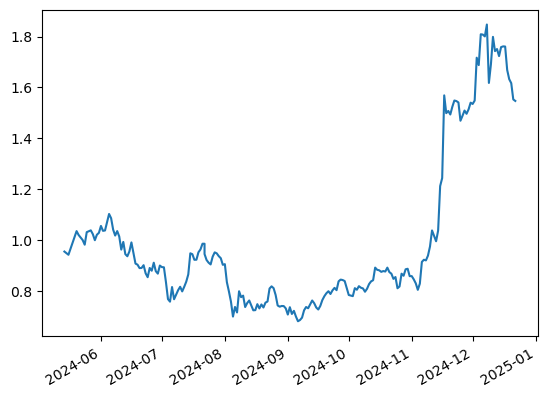

In [37]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [39]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [42]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [43]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT', 'BTCUSDT',
       'CRVUSDT', 'DOGEUSDT', 'DOTUSDT', 'ENSUSDT', 'EOSUSDT', 'ETCUSDT',
       'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT',
       'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT', 'IMXUSDT',
       'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT', 'LTCUSDT', 'MKRUSDT',
       'NEARUSDT', 'OMUSDT', 'OPUSDT', 'PEPEUSDT', 'QNTUSDT', 'RAYUSDT',
       'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT', 'STXUSDT',
       'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT', 'USDCUSDT',
       'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT', 'XLMUSDT', 'XRPUSDT',
       'XTZUSDT'],
      dtype='object')

In [44]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [47]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.4160
BNBUSDT,0.1991
PEPEUSDT,0.1162
SUIUSDT,0.1161
XRPUSDT,0.0925
TRXUSDT,0.0489
AAVEUSDT,0.0070
JASMYUSDT,0.0042
BTCUSDT,0.0000
RAYUSDT,0.0000


In [48]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.396821
BTCUSDT,0.300000
SUIUSDT,0.095103
PEPEUSDT,0.080746
BNBUSDT,0.053163
TRXUSDT,0.039076
XRPUSDT,0.035092


### Current results

In [50]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [51]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.431406
OMUSDT,0.396762
TRXUSDT,0.171833


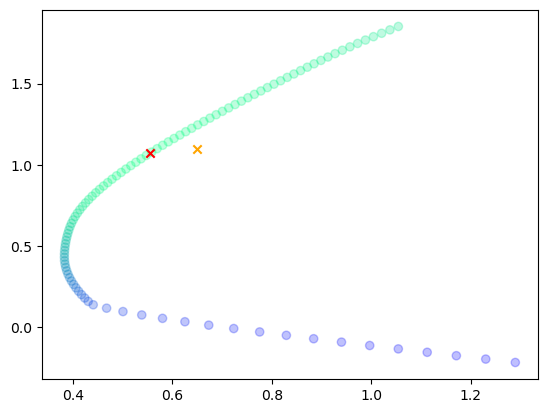

In [52]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

## Real Portfolio vs Optimal

In [54]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1701.633387,0.459420,0.396762,0.062658
BTCUSDT,849.108519,0.229249,0.431406,-0.202157
JASMYUSDT,425.747772,0.114946,0.000000,0.000000
SOLUSDT,330.999216,0.089366,0.000000,0.000000
ETHUSDT,231.045359,0.062379,0.000000,0.000000
TRXUSDT,121.104393,0.032697,0.171833,-0.139136
BBUSDT,43.095795,0.011635,0.000000,0.000000
BNBUSDT,1.142170,0.000308,0.000000,0.000000
PEPEUSDT,0.000004,0.000000,0.000000,0.000000


In [55]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1701.633387,0.459420,0.396821,0.062599
BTCUSDT,849.108519,0.229249,0.300000,-0.070751
JASMYUSDT,425.747772,0.114946,0.000000,0.000000
SOLUSDT,330.999216,0.089366,0.000000,0.000000
ETHUSDT,231.045359,0.062379,0.000000,0.000000
TRXUSDT,121.104393,0.032697,0.039076,-0.006379
BBUSDT,43.095795,0.011635,0.000000,0.000000
BNBUSDT,1.142170,0.000308,0.053163,-0.052855
PEPEUSDT,0.000004,0.000000,0.080746,-0.080746
SUIUSDT,0.000000,0.000000,0.095103,0.000000


# Risk Reward Analysis

In [57]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [58]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

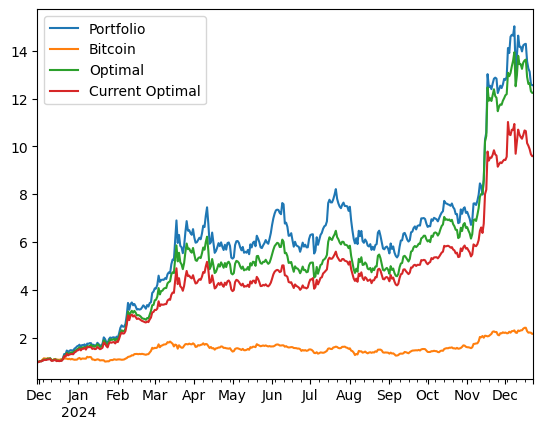

In [59]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [60]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

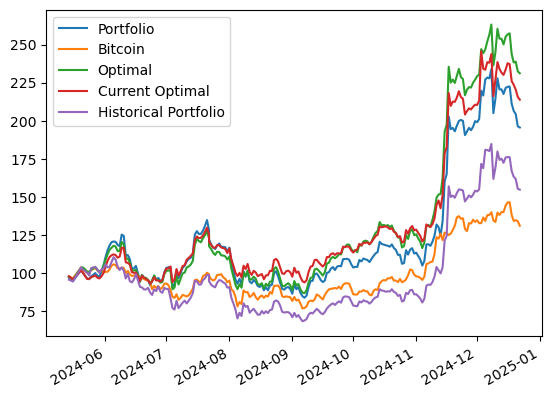

In [61]:
((1+current_perf).cumprod()*100).plot()

In [62]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-12-13,220.591092,140.016510,253.812214,231.568621,175.078776
2024-12-14,217.574370,140.010643,250.114691,230.097190,172.317363
2024-12-15,221.526784,144.151053,255.075162,233.525098,175.836410
2024-12-16,222.230807,146.334930,256.695846,237.787767,176.121825
2024-12-17,222.523793,146.438485,257.403774,237.152673,176.070219
2024-12-18,211.111016,138.019474,243.757546,225.999949,166.879687
2024-12-19,206.449857,134.189836,238.271989,223.623560,163.265422
2024-12-20,204.400669,134.662061,238.797552,220.395961,161.692923
2024-12-21,196.329670,133.953262,232.444532,215.635670,155.314800
2024-12-22,195.549112,131.022237,231.160170,213.841682,154.715129


## Volatilities

In [64]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.655059
 dtype: float64,
 0.6558763846806933)

In [65]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.64861
 dtype: float64,
 0.6486103527914934)

In [66]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.725970
Bitcoin            0.433981
Optimal            0.655876
Current Optimal    0.620775
dtype: float64

In [67]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4591407187063195

## Risk Contribution

In [69]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.078376,0.053163,0.006251,0.018065,0.001502,0.016563
BTCUSDT,0.359754,0.300000,0.031354,0.127314,0.039404,0.087910
OMUSDT,18.932097,0.396821,0.918598,0.690461,0.588832,0.101629
PEPEUSDT,0.333073,0.080746,0.019667,0.076599,0.024318,0.052280
SUIUSDT,0.251892,0.095103,0.016491,0.062518,0.019362,0.043157
TRXUSDT,0.029999,0.039076,0.003283,0.010517,0.001692,0.008825
XRPUSDT,0.056574,0.035092,0.004356,0.014525,0.001257,0.013268


In [70]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.914089,0.396762,0.601710,0.685684,0.568182,0.117502
BTCUSDT,0.178799,0.431406,0.280098,0.190628,0.102424,0.088204
TRXUSDT,0.085653,0.171833,0.118192,0.123687,0.073368,0.050319


In [71]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.070487,0.464646,0.701226,0.690891,0.570205,0.120686
BTCUSDT,0.096288,0.232323,0.150105,0.091026,0.021736,0.069290
JASMYUSDT,0.010074,0.111111,0.055356,0.106370,0.035173,0.071197
SOLUSDT,0.003903,0.090909,0.043309,0.062208,0.008202,0.054006
ETHUSDT,-0.000574,0.060606,0.027422,0.027555,0.002622,0.024933
TRXUSDT,0.015105,0.030303,0.020742,0.011746,0.001670,0.010077
BBUSDT,-0.006070,0.010101,0.001842,0.010203,0.000403,0.009800


# Value At Risk

## Historical

### Optimal Weights

In [75]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.052255197544711786, -0.07612287567124329)

### Current Weights

In [77]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.048674116719170935, -0.07271629663975251)

In [78]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [79]:
var=historical_var.iloc[row]
var

OMUSDT      -0.034467
BTCUSDT     -0.002169
JASMYUSDT   -0.006170
SOLUSDT     -0.002797
ETHUSDT     -0.001674
TRXUSDT     -0.000434
BBUSDT      -0.001258
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.048970
Name: 2024-07-22 00:00:00, dtype: float64

In [80]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.043311
BTCUSDT     -0.008137
JASMYUSDT   -0.010274
SOLUSDT     -0.006189
ETHUSDT     -0.002890
TRXUSDT     -0.000984
BBUSDT      -0.000931
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.072716
dtype: float64

## Parametric

### Optimal Weights

In [83]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06795931308573898, -0.08710504966648461)

### Current Weights

In [85]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06720643564178358, -0.08614006894241852)

## Multivariate

### Optimal Weights

In [88]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06011130874992181, -0.07672925448624866)

### Current Weights

In [90]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.0635435355383935, -0.08072759119933605)

In [91]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.044681
BTCUSDT     -0.005018
JASMYUSDT   -0.005725
SOLUSDT     -0.004279
ETHUSDT     -0.001628
TRXUSDT     -0.000694
BBUSDT      -0.000587
Portfolio   -0.062612
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [95]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.060979453198337585, -0.07884908636898645)

### Current Weights

In [97]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06300036004617389, -0.07937229657966796)

In [98]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.043508
BTCUSDT     -0.005779
JASMYUSDT   -0.006890
SOLUSDT     -0.003660
ETHUSDT     -0.001651
TRXUSDT     -0.000709
BBUSDT      -0.000641
Portfolio   -0.062838
dtype: float64

## Student Copula

### Optimal Weights

In [101]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.058994256559866315, -0.0766116069127429)

### Current Weights

In [103]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06448890602050611, -0.0828705424862961)

In [104]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.044475
BTCUSDT     -0.005166
JASMYUSDT   -0.007725
SOLUSDT     -0.003719
ETHUSDT     -0.001455
TRXUSDT     -0.000864
BBUSDT      -0.000686
Portfolio   -0.064090
dtype: float64

## Gumbel Copula

### Optimal Weights

In [107]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.11554168864142213, -0.1645446246394511)

### Current Weights

In [109]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.11182517851067425, -0.15975071582019798)

In [110]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.104646
BTCUSDT     -0.002511
JASMYUSDT   -0.005970
SOLUSDT      0.000632
ETHUSDT     -0.000495
TRXUSDT      0.000217
BBUSDT      -0.000125
Portfolio   -0.112898
dtype: float64

## Monte Carlo

### Optimal

In [113]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [114]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07088897370905334, -0.08768987863402057)

### Current Weights

In [116]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06841441936323021, -0.0856345795681951)

In [117]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.046125
BTCUSDT     -0.007129
JASMYUSDT   -0.007599
SOLUSDT     -0.004346
ETHUSDT     -0.002133
TRXUSDT     -0.000751
BBUSDT      -0.000701
Portfolio   -0.068784
dtype: float64

## VaR Violation

In [119]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.056744,-0.096036,-0.077929,-0.024569
2024-01-15,-0.056744,-0.096080,-0.079802,0.022473
2024-01-16,-0.056744,-0.095515,-0.081670,0.042403
2024-01-17,-0.056744,-0.097440,-0.080383,-0.028629
2024-01-18,-0.056744,-0.100325,-0.084914,-0.039522
...,...,...,...,...
2024-12-19,-0.087617,-0.076732,-0.074173,-0.022504
2024-12-20,-0.087617,-0.076551,-0.072833,0.002206
2024-12-21,-0.087617,-0.077071,-0.076427,-0.026604
2024-12-22,-0.087617,-0.076673,-0.078264,-0.005525


In [120]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.035509,-0.084126,-0.079966,-0.016883
2024-05-29,-0.035509,-0.081559,-0.073321,-0.008783
2024-05-30,-0.035509,-0.071333,-0.068304,0.034916
2024-05-31,-0.035509,-0.072391,-0.066649,0.038388
2024-06-01,-0.035509,-0.076024,-0.066252,0.053383
...,...,...,...,...
2024-12-19,-0.113525,-0.105934,-0.107012,-0.022079
2024-12-20,-0.113525,-0.100740,-0.107850,-0.009926
2024-12-21,-0.113525,-0.102349,-0.112536,-0.039486
2024-12-22,-0.113525,-0.102313,-0.110941,-0.003976


<Axes: >

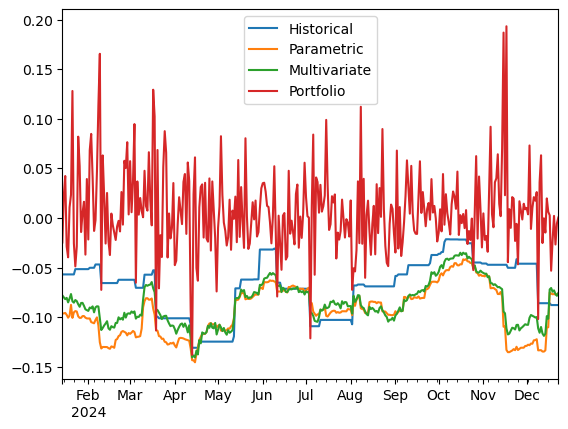

In [121]:
var_data.plot()

<Axes: >

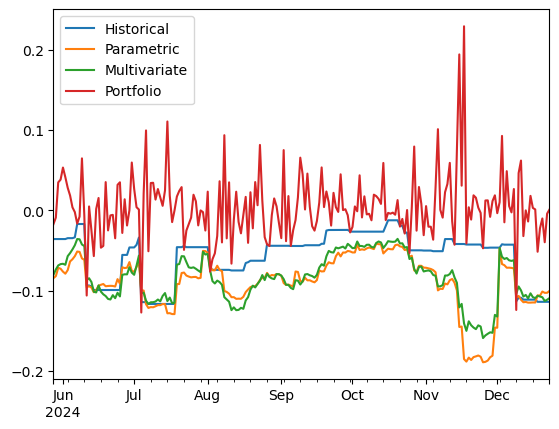

In [122]:
current_var_data.plot()

In [123]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.026087,0.011594,0.011594
Kupiec Stat,4.995369,15.336442,15.336442
P-value,0.025415,0.00009,0.00009


In [124]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.061905,0.019048,0.019048
Kupiec Stat,0.584387,5.488869,5.488869
P-value,0.444598,0.019138,0.019138


# Principal Component Analysis

## Historical PCA

In [127]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77123625, 0.07319311, 0.0587622 , 0.05172605, 0.04508239])

In [128]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.015388
ADAUSDT     0.015862
ALGOUSDT    0.017757
APTUSDT     0.016622
ARBUSDT     0.017506
              ...   
WBTCUSDT    0.009517
WLDUSDT     0.022756
XLMUSDT     0.012482
XRPUSDT     0.010894
XTZUSDT     0.016495
Name: PC1, Length: 61, dtype: float64

<Axes: >

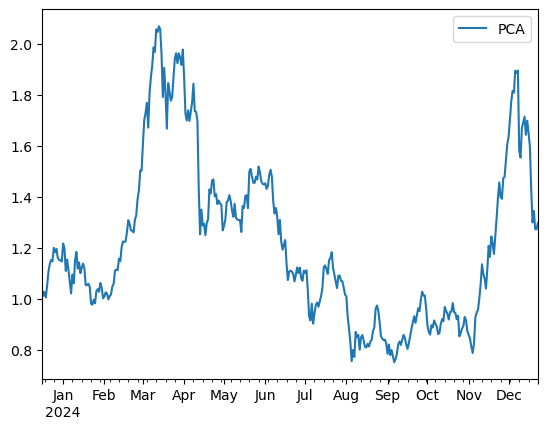

In [129]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

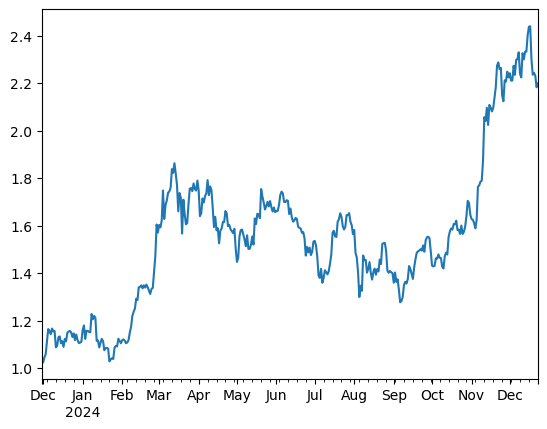

In [130]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [131]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.423602
WBETHUSDT    0.425066
ETHUSDT      0.425238
ATOMUSDT     0.453118
               ...   
FLOKIUSDT    1.127742
WLDUSDT      1.134530
BONKUSDT     1.135308
PEPEUSDT     1.182214
OMUSDT       1.541163
Length: 62, dtype: float64

<Axes: >

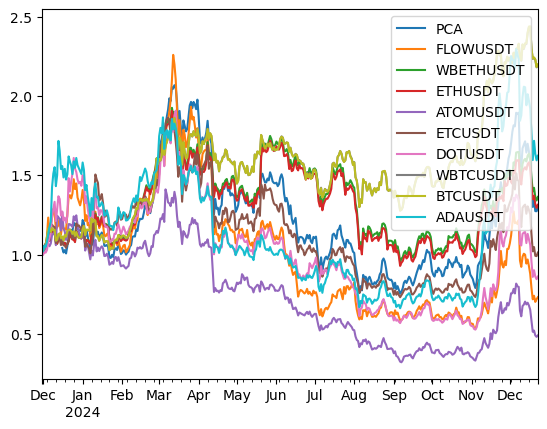

In [132]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

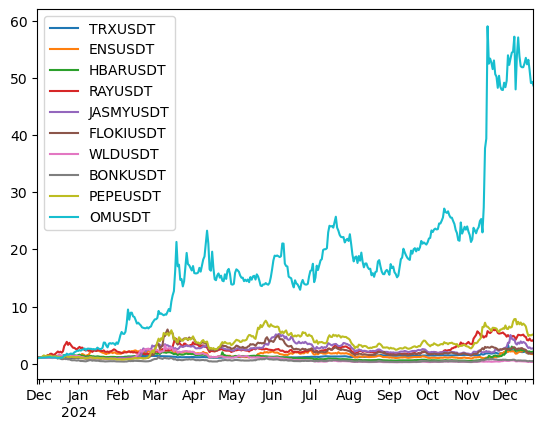

In [133]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [135]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.5411504 , 0.15075671, 0.13123203, 0.10246999, 0.07439086])

In [136]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.096398
BTCUSDT      0.061276
JASMYUSDT    0.168930
SOLUSDT      0.101630
ETHUSDT      0.083336
TRXUSDT      0.050538
BBUSDT       0.214106
BNBUSDT      0.067137
PEPEUSDT     0.156647
Name: PC1, dtype: float64

<Axes: >

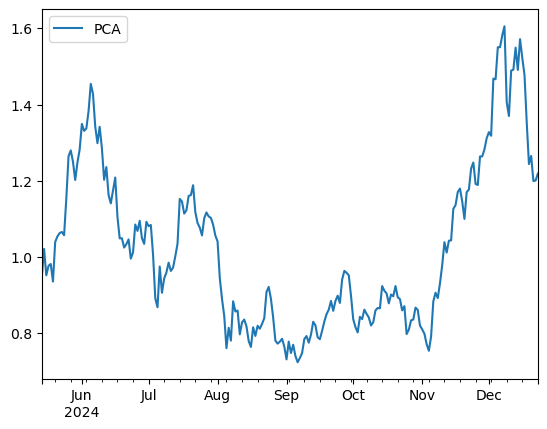

In [137]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

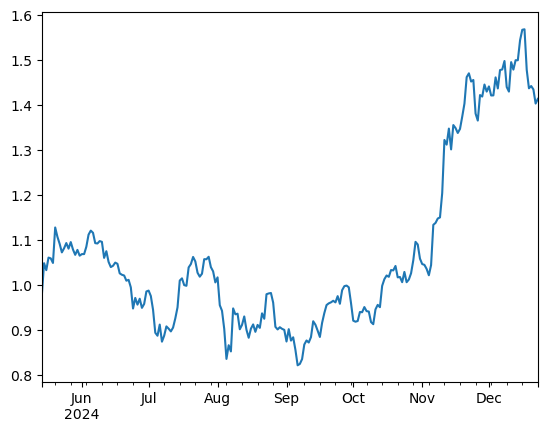

In [138]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [139]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
SOLUSDT      0.396055
ETHUSDT      0.411816
BNBUSDT      0.423817
BTCUSDT      0.440004
JASMYUSDT    0.648298
PEPEUSDT     0.717053
BBUSDT       0.738101
TRXUSDT      0.888346
OMUSDT       0.900279
dtype: float64

<Axes: >

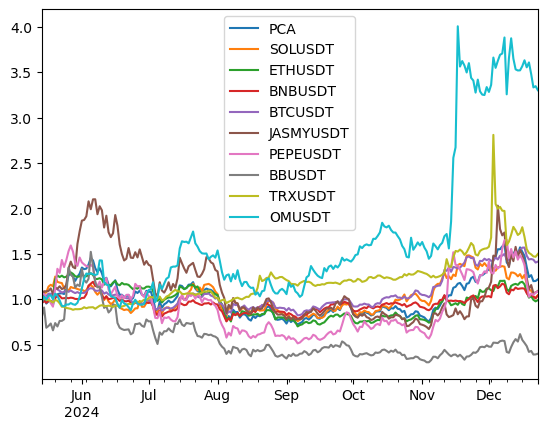

In [140]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [142]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.906312
BBUSDT       1.582089
JASMYUSDT    1.263560
SOLUSDT      1.148136
BTCUSDT      1.000000
ETHUSDT      0.962803
OMUSDT       0.879904
BNBUSDT      0.666833
TRXUSDT      0.283055
Name: BTCUSDT, dtype: float64

In [143]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       2.741961
JASMYUSDT    2.508525
PEPEUSDT     1.679173
TRXUSDT      1.478545
SOLUSDT      1.295956
ETHUSDT      1.271540
BNBUSDT      1.031279
BTCUSDT      1.000000
OMUSDT       0.918534
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [145]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [146]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
ETHUSDT,0.416764
BTCUSDT,0.306244
BBUSDT,0.252036
OMUSDT,0.189028
JASMYUSDT,0.060432
PEPEUSDT,0.059448
BNBUSDT,0.013893
TRXUSDT,0.007876
SOLUSDT,-0.004990


### Regression to PCA

In [148]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.1494204349795314

In [149]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.274140
BNBUSDT      1.133997
PCA          1.000000
ETHUSDT      0.995004
SOLUSDT      0.812251
JASMYUSDT    0.420066
PEPEUSDT     0.384479
BBUSDT       0.357001
OMUSDT       0.234804
TRXUSDT      0.194057
dtype: float64

In [150]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.930330
BNBUSDT      1.795372
ETHUSDT      1.584285
SOLUSDT      1.256383
PCA          1.000000
TRXUSDT      0.834081
JASMYUSDT    0.685800
BBUSDT       0.523528
PEPEUSDT     0.522340
OMUSDT       0.491019
dtype: float64

### Correlation Matrix

<Axes: >

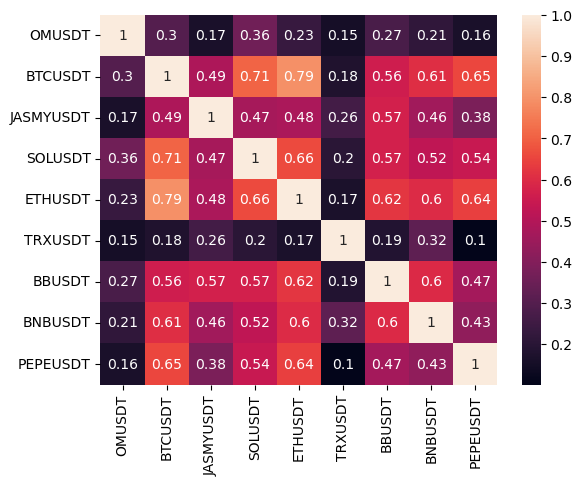

In [152]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

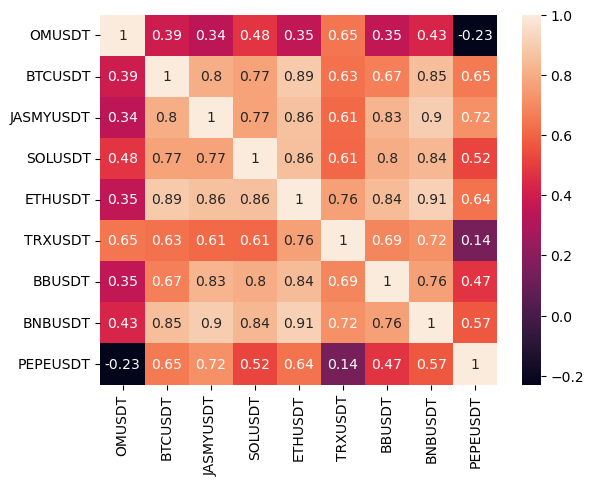

In [153]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [155]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.00000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.150852,0.000000,0.000000,0.223209,0.00000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.00000,0.000000,0.000000
2024-07-22,0.133242,0.414562,0.000000,0.112009,0.000000,0.340186,0.00000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.00000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.00000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.71256,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.00000,0.000000,0.130336


In [ ]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-05-17,0.007546,0.0,0.0,0.0,0.0,0.021785,0.022813,0.0,0.0,0.0,...,0.702968,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-06-16,0.007546,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.173396,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-07-16,0.007546,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.806263,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-08-15,0.697232,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-09-14,0.007546,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.396044,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-10-14,0.007546,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.565505,0.006056,0.0,0.0,0.0,0.0,0.012791,0.000000,0.000000,0.0
2024-11-13,0.007546,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.135071,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-12-13,0.270384,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.013875,0.214295,0.0
2024-12-23,0.007546,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
